# EDA Step 5: 패턴 탐색 및 가설 형성

**목적**: 단순 관찰을 넘어서 구조적 이해로 확장

**탐색할 아이디어**:
1. Heavy User의 rating 패턴 심층 분석
2. 1-rating User/Item의 특성
3. User-Item 매칭 패턴
4. Rating 값별 특성 분석
5. 시계열적 패턴 (출판연도 기반)
6. Cold Start 대상의 특성
7. Author 기반 분석 심화
8. Test 데이터 특성 심층 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
books = pd.read_csv('../data/books.csv')
users = pd.read_csv('../data/users.csv')
train = pd.read_csv('../data/train_ratings.csv')
test = pd.read_csv('../data/test_ratings.csv')

In [2]:
# 기본 전처리

# 1. User별 통계
user_stats = train.groupby('user_id').agg(
    user_rating_count=('rating', 'count'),
    user_rating_mean=('rating', 'mean'),
    user_rating_std=('rating', 'std')
).reset_index()

# 2. Item별 통계
item_stats = train.groupby('isbn').agg(
    item_rating_count=('rating', 'count'),
    item_rating_mean=('rating', 'mean'),
    item_rating_std=('rating', 'std')
).reset_index()

# 3. Books 전처리
def extract_first_category(cat_str):
    if pd.isna(cat_str):
        return None
    try:
        cat_list = ast.literal_eval(cat_str)
        if isinstance(cat_list, list) and len(cat_list) > 0:
            return cat_list[0]
    except:
        pass
    return cat_str

books['category_main'] = books['category'].apply(extract_first_category)

# 4. Users 전처리
users['country'] = users['location'].str.split(', ').str[-1].str.strip().str.lower()

# 5. Train에 메타데이터 병합
train_merged = train.merge(users, on='user_id', how='left')
train_merged = train_merged.merge(books, on='isbn', how='left')
train_merged = train_merged.merge(user_stats, on='user_id', how='left')
train_merged = train_merged.merge(item_stats, on='isbn', how='left')

# 6. User Activity 그룹
activity_bins = [0, 1, 5, 20, 100, 10000]
activity_labels = ['1', '2-5', '6-20', '21-100', '100+']
train_merged['user_activity_group'] = pd.cut(train_merged['user_rating_count'], 
                                              bins=activity_bins, labels=activity_labels, right=True)

# 7. Item Popularity 그룹
pop_bins = [0, 1, 5, 20, 100, 10000]
pop_labels = ['1', '2-5', '6-20', '21-100', '100+']
train_merged['item_popularity_group'] = pd.cut(train_merged['item_rating_count'], 
                                                bins=pop_bins, labels=pop_labels, right=True)

print(f"전처리 완료: {train_merged.shape}")

전처리 완료: (306795, 24)


---
## 5.1 Heavy User의 Rating 패턴 심층 분석

**질문**: Heavy User들이 단순히 "후하게" 주는 건가, 아니면 다른 패턴이 있는가?

**가설**: Heavy User는 특정 장르(예: Fiction, Mystery)에 집중되어 있을 것

In [3]:
# Heavy User 정의 (상위 1%)
heavy_threshold = user_stats['user_rating_count'].quantile(0.99)
heavy_user_ids = user_stats[user_stats['user_rating_count'] >= heavy_threshold]['user_id'].tolist()

train_heavy = train_merged[train_merged['user_id'].isin(heavy_user_ids)]
train_normal = train_merged[~train_merged['user_id'].isin(heavy_user_ids)]

print(f"Heavy User 기준: {heavy_threshold:.0f}개 이상 rating")
print(f"Heavy User 수: {len(heavy_user_ids):,}명")
print(f"Heavy User Rating 수: {len(train_heavy):,}개 ({len(train_heavy)/len(train)*100:.1f}%)")

Heavy User 기준: 66개 이상 rating
Heavy User 수: 601명
Heavy User Rating 수: 93,467개 (30.5%)



[Rating 분포 비교]

Heavy User Rating 분포:
rating
1      2.85
2      4.36
3      3.66
4      4.41
5      3.55
6      6.75
7     15.40
8     24.24
9     18.17
10    16.61
Name: count, dtype: float64

Normal User Rating 분포:
rating
1      4.96
2      4.15
3      3.33
4      4.03
5      5.06
6      8.91
7     18.06
8     23.88
9     14.85
10    12.78
Name: count, dtype: float64


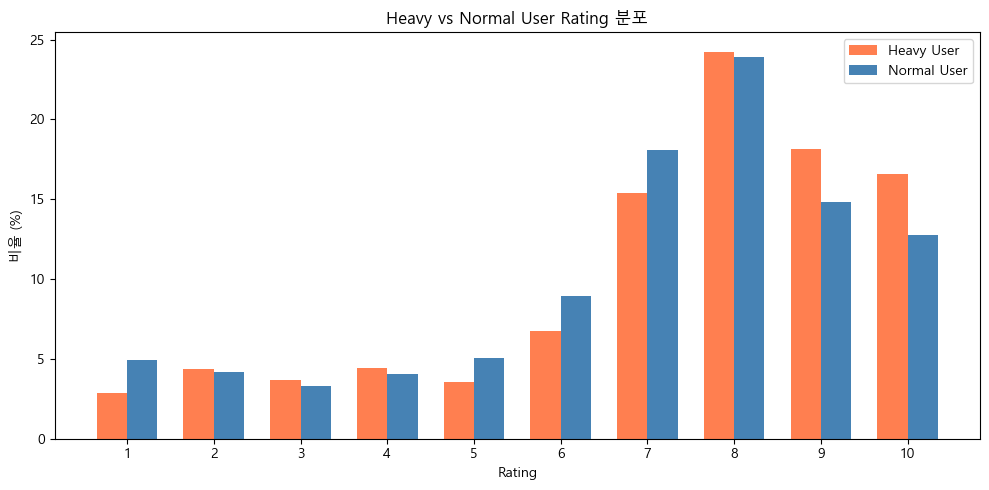

In [4]:
# Heavy vs Normal Rating 분포 비교
print("\n[Rating 분포 비교]")
print("\nHeavy User Rating 분포:")
heavy_dist = train_heavy['rating'].value_counts().sort_index()
heavy_pct = (heavy_dist / len(train_heavy) * 100).round(2)
print(heavy_pct)

print("\nNormal User Rating 분포:")
normal_dist = train_normal['rating'].value_counts().sort_index()
normal_pct = (normal_dist / len(train_normal) * 100).round(2)
print(normal_pct)

# 시각화
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(1, 11)
width = 0.35

ax.bar(x - width/2, heavy_pct.values, width, label='Heavy User', color='coral')
ax.bar(x + width/2, normal_pct.values, width, label='Normal User', color='steelblue')
ax.set_xlabel('Rating')
ax.set_ylabel('비율 (%)')
ax.set_title('Heavy vs Normal User Rating 분포')
ax.set_xticks(x)
ax.legend()

plt.tight_layout()
plt.show()

In [5]:
# Heavy User가 선호하는 Category
print("\n[Heavy User vs Normal User 선호 Category]")

heavy_cat = train_heavy['category_main'].value_counts().head(10)
normal_cat = train_normal['category_main'].value_counts().head(10)

# 비율로 비교
heavy_cat_pct = (heavy_cat / len(train_heavy) * 100).round(2)
normal_cat_pct = (normal_cat / len(train_normal) * 100).round(2)

cat_compare = pd.DataFrame({
    'Heavy User (%)': heavy_cat_pct,
    'Normal User (%)': normal_cat_pct
}).fillna(0)

print(cat_compare)


[Heavy User vs Normal User 선호 Category]
                           Heavy User (%)  Normal User (%)
category_main                                             
Biography & Autobiography            2.03             2.69
Body, Mind & Spirit                  0.58             0.56
Business & Economics                 0.00             0.53
Cooking                              0.54             0.00
Family & Relationships               0.00             0.50
Fiction                             34.81            35.64
History                              0.84             0.88
Humor                                1.19             0.95
Juvenile Fiction                     4.31             3.75
Juvenile Nonfiction                  0.74             0.00
Religion                             0.72             0.81
Social Science                       0.50             0.55


In [6]:
# Heavy User가 평가한 책들의 Popularity 분포
print("\n[Heavy User가 평가한 Item의 Popularity]")

heavy_item_pop = train_heavy['item_rating_count'].describe()
normal_item_pop = train_normal['item_rating_count'].describe()

pop_compare = pd.DataFrame({
    'Heavy User': heavy_item_pop,
    'Normal User': normal_item_pop
}).round(2)

print(pop_compare)

print(f"\nHeavy User가 평가한 Item 중 인기 Item(10+ rating) 비율: {(train_heavy['item_rating_count'] >= 10).mean()*100:.1f}%")
print(f"Normal User가 평가한 Item 중 인기 Item(10+ rating) 비율: {(train_normal['item_rating_count'] >= 10).mean()*100:.1f}%")


[Heavy User가 평가한 Item의 Popularity]
       Heavy User  Normal User
count    93467.00    213328.00
mean        12.68        22.85
std         33.29        52.91
min          1.00         1.00
25%          1.00         1.00
50%          3.00         4.00
75%          9.00        19.00
max        566.00       566.00

Heavy User가 평가한 Item 중 인기 Item(10+ rating) 비율: 24.3%
Normal User가 평가한 Item 중 인기 Item(10+ rating) 비율: 36.2%


In [7]:
# Heavy User 간 취향 유사도 (같은 책을 평가한 비율)
print("\n[Heavy User 간 Item 중복도]")

# 각 Heavy User가 평가한 item set
heavy_user_items = train_heavy.groupby('user_id')['isbn'].apply(set).to_dict()

# 샘플링하여 유사도 계산 (전체는 너무 오래 걸림)
sample_users = list(heavy_user_items.keys())[:50]  # 상위 50명

overlaps = []
for i, u1 in enumerate(sample_users):
    for u2 in sample_users[i+1:]:
        items1 = heavy_user_items[u1]
        items2 = heavy_user_items[u2]
        overlap = len(items1 & items2)
        union = len(items1 | items2)
        jaccard = overlap / union if union > 0 else 0
        overlaps.append({'overlap': overlap, 'jaccard': jaccard})

overlap_df = pd.DataFrame(overlaps)
print(f"Heavy User 쌍 간 공통 Item 수:")
print(overlap_df['overlap'].describe())
print(f"\n평균 Jaccard 유사도: {overlap_df['jaccard'].mean():.4f}")


[Heavy User 간 Item 중복도]
Heavy User 쌍 간 공통 Item 수:
count    1225.000000
mean        1.411429
std         5.059502
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       112.000000
Name: overlap, dtype: float64

평균 Jaccard 유사도: 0.0024


---
## 5.2 1-Rating User/Item의 특성

**질문**: 1개 rating만 있는 User/Item은 어떤 특성을 가지는가?

**가설**: 1-rating은 극단적 평점(매우 좋거나 매우 나쁨)일 가능성이 높음

In [8]:
# 1-rating User/Item 추출
one_rating_users = user_stats[user_stats['user_rating_count'] == 1]['user_id'].tolist()
one_rating_items = item_stats[item_stats['item_rating_count'] == 1]['isbn'].tolist()

train_one_user = train_merged[train_merged['user_id'].isin(one_rating_users)]
train_one_item = train_merged[train_merged['isbn'].isin(one_rating_items)]
train_multi_user = train_merged[~train_merged['user_id'].isin(one_rating_users)]
train_multi_item = train_merged[~train_merged['isbn'].isin(one_rating_items)]

print(f"1-rating User 수: {len(one_rating_users):,}명 ({len(one_rating_users)/len(user_stats)*100:.1f}%)")
print(f"1-rating Item 수: {len(one_rating_items):,}개 ({len(one_rating_items)/len(item_stats)*100:.1f}%)")

1-rating User 수: 34,617명 (57.9%)
1-rating Item 수: 88,392개 (68.1%)


In [9]:
# 1-rating User의 Rating 분포 vs Multi-rating User
print("\n[1-Rating User vs Multi-Rating User의 Rating 분포]")

one_user_rating_dist = train_one_user['rating'].value_counts().sort_index()
multi_user_rating_dist = train_multi_user['rating'].value_counts().sort_index()

one_user_pct = (one_user_rating_dist / len(train_one_user) * 100).round(2)
multi_user_pct = (multi_user_rating_dist / len(train_multi_user) * 100).round(2)

rating_compare = pd.DataFrame({
    '1-Rating User (%)': one_user_pct,
    'Multi-Rating User (%)': multi_user_pct
})
print(rating_compare)

print(f"\n1-Rating User 평균 Rating: {train_one_user['rating'].mean():.2f}")
print(f"Multi-Rating User 평균 Rating: {train_multi_user['rating'].mean():.2f}")


[1-Rating User vs Multi-Rating User의 Rating 분포]
        1-Rating User (%)  Multi-Rating User (%)
rating                                          
1                    5.36                   4.19
2                    3.68                   4.28
3                    2.86                   3.50
4                    3.48                   4.23
5                    5.25                   4.52
6                    9.17                   8.13
7                   18.60                  17.08
8                   25.38                  23.81
9                   14.10                  16.09
10                  12.12                  14.17

1-Rating User 평균 Rating: 6.98
Multi-Rating User 평균 Rating: 7.08


In [10]:
# 1-rating Item의 Rating 분포
print("\n[1-Rating Item vs Multi-Rating Item의 Rating 분포]")

one_item_rating_dist = train_one_item['rating'].value_counts().sort_index()
multi_item_rating_dist = train_multi_item['rating'].value_counts().sort_index()

one_item_pct = (one_item_rating_dist / len(train_one_item) * 100).round(2)
multi_item_pct = (multi_item_rating_dist / len(train_multi_item) * 100).round(2)

item_rating_compare = pd.DataFrame({
    '1-Rating Item (%)': one_item_pct,
    'Multi-Rating Item (%)': multi_item_pct
})
print(item_rating_compare)

print(f"\n1-Rating Item 평균 Rating: {train_one_item['rating'].mean():.2f}")
print(f"Multi-Rating Item 평균 Rating: {train_multi_item['rating'].mean():.2f}")


[1-Rating Item vs Multi-Rating Item의 Rating 분포]
        1-Rating Item (%)  Multi-Rating Item (%)
rating                                          
1                    4.60                   4.20
2                    5.33                   3.76
3                    4.38                   3.04
4                    5.29                   3.68
5                    4.73                   4.55
6                    8.28                   8.24
7                   16.66                  17.49
8                   21.92                  24.83
9                   14.61                  16.37
10                  14.21                  13.83

1-Rating Item 평균 Rating: 6.88
Multi-Rating Item 평균 Rating: 7.14


In [11]:
# 1-rating User의 메타데이터 특성
print("\n[1-Rating User의 Age 분포]")

one_user_age = train_one_user['age'].dropna()
multi_user_age = train_multi_user['age'].dropna()

print(f"1-Rating User 평균 Age: {one_user_age.mean():.1f}")
print(f"Multi-Rating User 평균 Age: {multi_user_age.mean():.1f}")

print("\n[1-Rating User의 Country 분포 (상위 5개)]")
print((train_one_user['country'].value_counts().head(5) / len(train_one_user) * 100).round(2))


[1-Rating User의 Age 분포]
1-Rating User 평균 Age: 36.0
Multi-Rating User 평균 Age: 36.7

[1-Rating User의 Country 분포 (상위 5개)]
country
usa               63.04
canada             9.32
germany            5.53
united kingdom     4.74
australia          2.96
Name: count, dtype: float64


In [12]:
# 1-rating Item의 메타데이터 특성
print("\n[1-Rating Item의 Category 분포 (상위 10개)]")

one_item_cat = train_one_item['category_main'].value_counts().head(10)
one_item_cat_pct = (one_item_cat / len(train_one_item) * 100).round(2)
print(one_item_cat_pct)

print("\n[1-Rating Item의 출판 연도 통계]")
print(f"1-Rating Item 평균 출판연도: {train_one_item['year_of_publication'].mean():.0f}")
print(f"Multi-Rating Item 평균 출판연도: {train_multi_item['year_of_publication'].mean():.0f}")


[1-Rating Item의 Category 분포 (상위 10개)]
category_main
Fiction                      17.42
Juvenile Fiction              3.73
Biography & Autobiography     2.12
History                       1.43
Religion                      1.36
Juvenile Nonfiction           1.11
Social Science                0.88
Cooking                       0.80
Business & Economics          0.79
Body, Mind & Spirit           0.75
Name: count, dtype: float64

[1-Rating Item의 출판 연도 통계]
1-Rating Item 평균 출판연도: 1994
Multi-Rating Item 평균 출판연도: 1996


---
## 5.3 User-Item 매칭 패턴

**질문**: 특정 User 그룹이 특정 Item 그룹을 선호하는가?

**가설**: 젊은 user는 Juvenile Fiction을, 50대 이상은 Religion/History를 선호할 것

In [13]:
# Age Group 생성
age_bins = [0, 20, 30, 40, 50, 100]
age_labels = ['~20', '20-30', '30-40', '40-50', '50+']
train_merged['age_group'] = pd.cut(train_merged['age'], bins=age_bins, labels=age_labels, right=False)

# Age Group × Category 교차 분석
print("[Age Group × Category 교차 분석]")

top_categories = train_merged['category_main'].value_counts().head(8).index.tolist()
train_top_cat = train_merged[train_merged['category_main'].isin(top_categories)]

# 각 연령대별 카테고리 비율
age_cat_cross = pd.crosstab(train_top_cat['age_group'], train_top_cat['category_main'], normalize='index') * 100
print(age_cat_cross.round(2))

[Age Group × Category 교차 분석]
category_main  Biography & Autobiography  Body, Mind & Spirit  Fiction  \
age_group                                                                
~20                                 3.03                 1.06    50.94   
20-30                               5.13                 1.52    75.77   
30-40                               5.25                 1.49    79.45   
40-50                               6.13                 1.24    78.02   
50+                                 5.12                 1.07    83.43   

category_main  History  Humor  Juvenile Fiction  Juvenile Nonfiction  Religion  
age_group                                                                       
~20               1.01   1.55             37.34                 4.30      0.76  
20-30             1.58   2.76             10.63                 1.05      1.56  
30-40             1.60   2.42              7.03                 0.99      1.76  
40-50             2.04   2.25              6.78

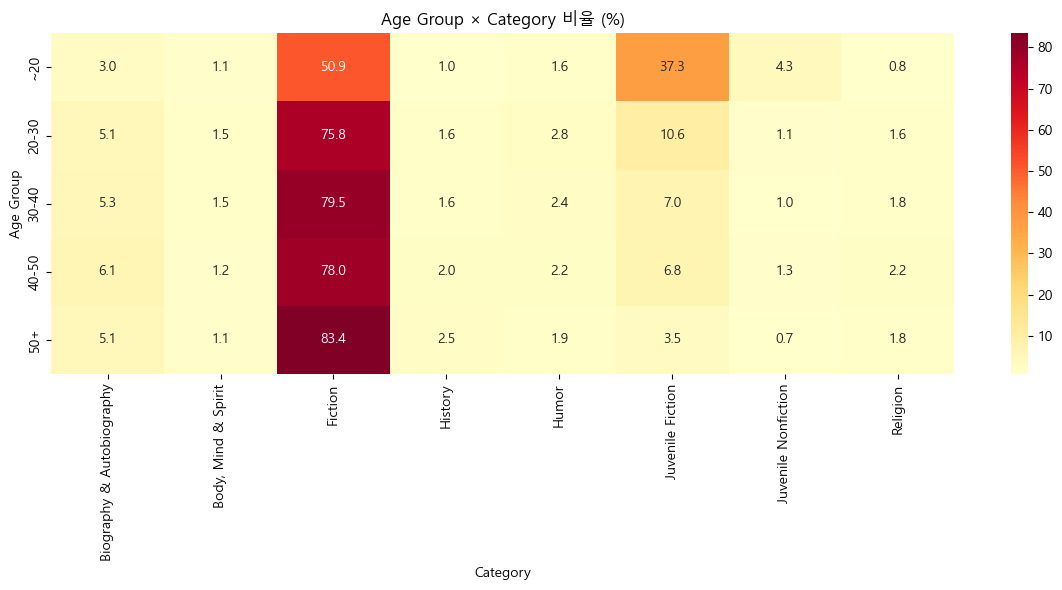

In [14]:
# 히트맵 시각화
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(age_cat_cross, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax)
ax.set_title('Age Group × Category 비율 (%)')
ax.set_xlabel('Category')
ax.set_ylabel('Age Group')
plt.tight_layout()
plt.show()

In [15]:
# User Activity × Item Popularity 교차 분석
print("\n[User Activity × Item Popularity 교차 분석]")

activity_pop_cross = pd.crosstab(train_merged['user_activity_group'], 
                                  train_merged['item_popularity_group'], 
                                  normalize='index') * 100
print(activity_pop_cross.round(2))


[User Activity × Item Popularity 교차 분석]
item_popularity_group      1    2-5   6-20  21-100  100+
user_activity_group                                     
1                      22.99  28.23  22.46   18.89  7.42
2-5                    24.16  27.36  22.63   19.31  6.54
6-20                   25.51  28.30  22.53   18.08  5.58
21-100                 29.07  29.22  21.43   15.78  4.50
100+                   37.67  31.39  18.76   10.18  2.00


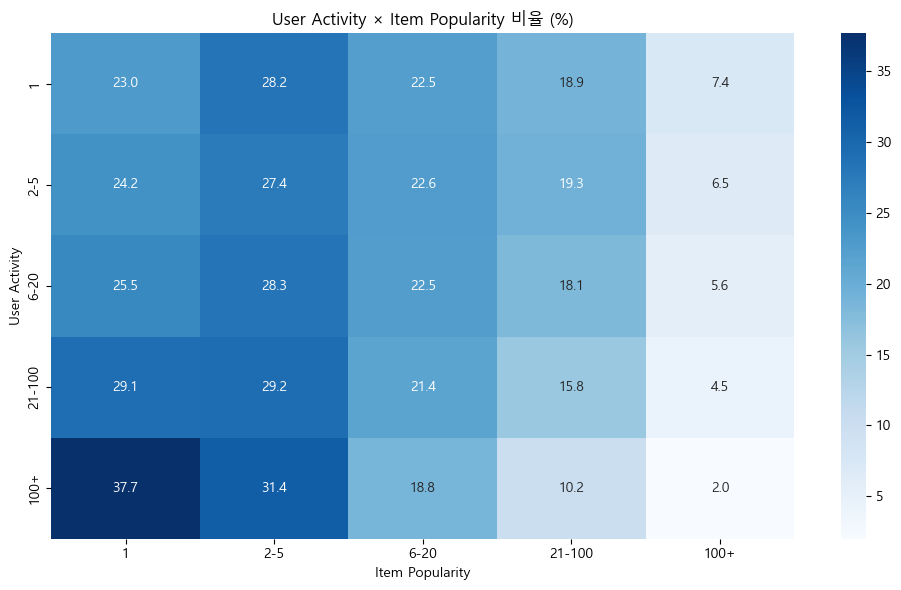


해석: 활발한 User일수록 비인기 Item도 많이 평가하는가?


In [16]:
# 히트맵 시각화
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(activity_pop_cross, annot=True, fmt='.1f', cmap='Blues', ax=ax)
ax.set_title('User Activity × Item Popularity 비율 (%)')
ax.set_xlabel('Item Popularity')
ax.set_ylabel('User Activity')
plt.tight_layout()
plt.show()

print("\n해석: 활발한 User일수록 비인기 Item도 많이 평가하는가?")

In [17]:
# Country × Category 교차 분석 (상위 5개 국가)
print("\n[Country × Category 교차 분석 (상위 5개 국가)]")

top_countries = ['usa', 'canada', 'united kingdom', 'germany', 'australia']
train_top_country = train_merged[train_merged['country'].isin(top_countries)]
train_top_country_cat = train_top_country[train_top_country['category_main'].isin(top_categories)]

country_cat_cross = pd.crosstab(train_top_country_cat['country'], 
                                 train_top_country_cat['category_main'], 
                                 normalize='index') * 100
print(country_cat_cross.round(2))


[Country × Category 교차 분석 (상위 5개 국가)]
category_main   Biography & Autobiography  Body, Mind & Spirit  Fiction  \
country                                                                   
australia                            8.22                 3.22    71.11   
canada                               5.30                 1.28    77.60   
germany                              3.05                 0.54    87.75   
united kingdom                       7.62                 2.60    74.98   
usa                                  5.52                 1.16    77.55   

category_main   History  Humor  Juvenile Fiction  Juvenile Nonfiction  \
country                                                                 
australia          2.20   2.31              9.51                 1.61   
canada             1.65   3.43              8.17                 1.05   
germany            0.74   0.68              6.64                 0.27   
united kingdom     2.81   2.27              7.27                 1.18 

---
## 5.4 Rating 값별 특성 분석

**질문**: 1점을 주는 경우 vs 10점을 주는 경우, 어떤 차이가 있는가?

**가설**: 저평점은 특정 category나 publisher에 집중되어 있을 것

In [18]:
# 저평점 (1-3) vs 고평점 (8-10) 그룹
train_low = train_merged[train_merged['rating'] <= 3]
train_high = train_merged[train_merged['rating'] >= 8]

print(f"저평점 (1-3): {len(train_low):,}개 ({len(train_low)/len(train)*100:.1f}%)")
print(f"고평점 (8-10): {len(train_high):,}개 ({len(train_high)/len(train)*100:.1f}%)")

저평점 (1-3): 36,698개 (12.0%)
고평점 (8-10): 165,040개 (53.8%)


In [19]:
# 저평점 vs 고평점 Category 분포
print("\n[저평점 vs 고평점 Category 분포]")

low_cat = train_low['category_main'].value_counts().head(10)
high_cat = train_high['category_main'].value_counts().head(10)

low_cat_pct = (low_cat / len(train_low) * 100).round(2)
high_cat_pct = (high_cat / len(train_high) * 100).round(2)

cat_rating_compare = pd.DataFrame({
    '저평점 (%)': low_cat_pct,
    '고평점 (%)': high_cat_pct
}).fillna(0)

print(cat_rating_compare)


[저평점 vs 고평점 Category 분포]
                           저평점 (%)  고평점 (%)
category_main                              
Biography & Autobiography     2.23     2.65
Body, Mind & Spirit           0.60     0.60
Business & Economics          0.63     0.00
Family & Relationships        0.63     0.49
Fiction                      35.94    34.23
History                       0.77     0.95
Humor                         0.84     1.13
Juvenile Fiction              3.20     4.53
Juvenile Nonfiction           0.57     0.60
Religion                      0.74     0.89
Social Science                0.00     0.53


In [20]:
# 저평점 vs 고평점 Publisher 분포
print("\n[저평점 vs 고평점 Publisher 분포 (상위 10개)]")

low_pub = train_low['publisher'].value_counts().head(10)
high_pub = train_high['publisher'].value_counts().head(10)

low_pub_pct = (low_pub / len(train_low) * 100).round(2)
high_pub_pct = (high_pub / len(train_high) * 100).round(2)

pub_rating_compare = pd.DataFrame({
    '저평점 (%)': low_pub_pct,
    '고평점 (%)': high_pub_pct
}).fillna(0)

print(pub_rating_compare)


[저평점 vs 고평점 Publisher 분포 (상위 10개)]
                          저평점 (%)  고평점 (%)
publisher                                 
Avon                         0.00     1.46
Ballantine Books             3.07     3.24
Bantam                       1.52     2.07
Bantam Books                 1.87     1.79
Berkley Publishing Group     2.55     2.24
Harlequin                    2.31     0.00
Jove Books                   1.38     0.00
Penguin Books                1.45     1.96
Perennial                    0.00     1.63
Pocket                       2.91     2.68
Signet Book                  1.77     1.74
Warner Books                 2.42     2.27


In [21]:
# 저평점을 많이 주는 User의 특성
print("\n[저평점을 많이 주는 User 분석]")

# 각 User의 저평점 비율 계산
user_low_ratio = train_merged.groupby('user_id').apply(
    lambda x: (x['rating'] <= 3).sum() / len(x) if len(x) >= 5 else np.nan
).dropna()

# 저평점 비율 상위 User
harsh_users = user_low_ratio[user_low_ratio >= 0.5].index.tolist()  # 50% 이상 저평점
generous_users = user_low_ratio[user_low_ratio <= 0.05].index.tolist()  # 5% 이하 저평점

print(f"까다로운 User (50%+ 저평점): {len(harsh_users)}명")
print(f"후한 User (5%- 저평점): {len(generous_users)}명")

# 까다로운 User vs 후한 User의 평균 rating
harsh_ratings = train_merged[train_merged['user_id'].isin(harsh_users)]
generous_ratings = train_merged[train_merged['user_id'].isin(generous_users)]

print(f"\n까다로운 User 평균 Rating: {harsh_ratings['rating'].mean():.2f}")
print(f"후한 User 평균 Rating: {generous_ratings['rating'].mean():.2f}")


[저평점을 많이 주는 User 분석]
까다로운 User (50%+ 저평점): 513명
후한 User (5%- 저평점): 4731명

까다로운 User 평균 Rating: 3.51
후한 User 평균 Rating: 8.04


In [22]:
# 저평점을 많이 받는 Item의 특성
print("\n[저평점을 많이 받는 Item 분석]")

# 각 Item의 저평점 비율 계산 (5개 이상 rating 받은 Item만)
item_low_ratio = train_merged.groupby('isbn').apply(
    lambda x: (x['rating'] <= 3).sum() / len(x) if len(x) >= 5 else np.nan
).dropna()

# 저평점 비율 상위 Item
bad_items = item_low_ratio[item_low_ratio >= 0.5].index.tolist()
good_items = item_low_ratio[item_low_ratio <= 0.05].index.tolist()

print(f"저평가 Item (50%+ 저평점): {len(bad_items)}개")
print(f"고평가 Item (5%- 저평점): {len(good_items)}개")

# 저평가 Item의 Category
bad_item_data = train_merged[train_merged['isbn'].isin(bad_items)]
print(f"\n저평가 Item의 Category 분포:")
print(bad_item_data['category_main'].value_counts().head(5))


[저평점을 많이 받는 Item 분석]
저평가 Item (50%+ 저평점): 136개
고평가 Item (5%- 저평점): 4394개

저평가 Item의 Category 분포:
category_main
Fiction                      924
Biography & Autobiography     40
Social Science                17
Humor                         16
Body, Mind & Spirit           16
Name: count, dtype: int64


---
## 5.5 시계열적 패턴 (출판연도 기반)

**질문**: 오래된 책 vs 최신 책의 평가 패턴이 다른가?

**가설**: 고전은 "검증된 명작"이라 rating이 높고, 최신은 양극화될 것

In [23]:
# 고전 vs 최신 정의
train_classic = train_merged[(train_merged['year_of_publication'] >= 1900) & 
                              (train_merged['year_of_publication'] < 1980)]
train_modern = train_merged[(train_merged['year_of_publication'] >= 2000) & 
                             (train_merged['year_of_publication'] <= 2006)]

print(f"고전 (1900-1979): {len(train_classic):,}개 rating")
print(f"최신 (2000-2006): {len(train_modern):,}개 rating")

고전 (1900-1979): 10,051개 rating
최신 (2000-2006): 110,239개 rating


In [24]:
# 고전 vs 최신 Rating 분포 비교
print("\n[고전 vs 최신 Rating 분포]")

classic_dist = train_classic['rating'].value_counts().sort_index()
modern_dist = train_modern['rating'].value_counts().sort_index()

classic_pct = (classic_dist / len(train_classic) * 100).round(2)
modern_pct = (modern_dist / len(train_modern) * 100).round(2)

era_compare = pd.DataFrame({
    '고전 (%)': classic_pct,
    '최신 (%)': modern_pct
})
print(era_compare)

print(f"\n고전 평균 Rating: {train_classic['rating'].mean():.2f} (std: {train_classic['rating'].std():.2f})")
print(f"최신 평균 Rating: {train_modern['rating'].mean():.2f} (std: {train_modern['rating'].std():.2f})")


[고전 vs 최신 Rating 분포]
        고전 (%)  최신 (%)
rating                
1         3.15    4.77
2         4.79    3.51
3         3.47    2.85
4         4.51    3.42
5         3.55    4.72
6         6.58    8.31
7        15.16   17.40
8        22.57   24.91
9        16.83   16.67
10       19.38   13.45

고전 평균 Rating: 7.30 (std: 2.46)
최신 평균 Rating: 7.13 (std: 2.40)


In [25]:
# 고전을 읽는 User vs 최신만 읽는 User
print("\n[고전 독자 vs 최신 독자 특성]")

classic_users = set(train_classic['user_id'].unique())
modern_users = set(train_modern['user_id'].unique())

only_classic = classic_users - modern_users
only_modern = modern_users - classic_users
both = classic_users & modern_users

print(f"고전만 읽는 User: {len(only_classic):,}명")
print(f"최신만 읽는 User: {len(only_modern):,}명")
print(f"둘 다 읽는 User: {len(both):,}명")

# 각 그룹의 평균 Age
only_classic_age = users[users['user_id'].isin(only_classic)]['age'].mean()
only_modern_age = users[users['user_id'].isin(only_modern)]['age'].mean()
both_age = users[users['user_id'].isin(both)]['age'].mean()

print(f"\n고전만 읽는 User 평균 Age: {only_classic_age:.1f}")
print(f"최신만 읽는 User 평균 Age: {only_modern_age:.1f}")
print(f"둘 다 읽는 User 평균 Age: {both_age:.1f}")


[고전 독자 vs 최신 독자 특성]
고전만 읽는 User: 1,851명
최신만 읽는 User: 29,692명
둘 다 읽는 User: 2,986명

고전만 읽는 User 평균 Age: 34.5
최신만 읽는 User 평균 Age: 37.1
둘 다 읽는 User 평균 Age: 34.8


In [26]:
# 출판연도와 User Age의 관계
print("\n[출판연도와 User Age의 관계]")

train_with_age_year = train_merged[(train_merged['age'].notna()) & 
                                    (train_merged['year_of_publication'] >= 1950)]

# 상관관계
corr = train_with_age_year['age'].corr(train_with_age_year['year_of_publication'])
print(f"User Age와 출판연도의 상관계수: {corr:.4f}")

# Age 그룹별 평균 출판연도
age_year = train_with_age_year.groupby('age_group', observed=True)['year_of_publication'].mean()
print(f"\nAge 그룹별 평균 출판연도:")
print(age_year.round(1))


[출판연도와 User Age의 관계]
User Age와 출판연도의 상관계수: 0.0241

Age 그룹별 평균 출판연도:
age_group
~20      1995.7
20-30    1995.6
30-40    1995.7
40-50    1995.5
50+      1996.5
Name: year_of_publication, dtype: float64


---
## 5.6 Cold Start 대상의 특성

**질문**: Test에서 Cold Start인 User/Item은 어떤 특성을 가지는가?

**가설**: Cold Item이라도 같은 Author의 다른 책 rating을 활용할 수 있을 것

In [27]:
# Cold User/Item 식별
train_users = set(train['user_id'].unique())
train_items = set(train['isbn'].unique())
test_users = set(test['user_id'].unique())
test_items = set(test['isbn'].unique())

cold_users = test_users - train_users
cold_items = test_items - train_items

print(f"Cold User 수: {len(cold_users):,}명")
print(f"Cold Item 수: {len(cold_items):,}개")

Cold User 수: 8,266명
Cold Item 수: 19,793개


In [28]:
# Cold User의 메타데이터
print("\n[Cold User vs Warm User 메타데이터 비교]")

cold_user_meta = users[users['user_id'].isin(cold_users)]
warm_user_meta = users[users['user_id'].isin(train_users)]

print(f"\nCold User 평균 Age: {cold_user_meta['age'].mean():.1f}")
print(f"Warm User 평균 Age: {warm_user_meta['age'].mean():.1f}")

print(f"\nCold User Age 결측률: {cold_user_meta['age'].isna().mean()*100:.1f}%")
print(f"Warm User Age 결측률: {warm_user_meta['age'].isna().mean()*100:.1f}%")

print(f"\nCold User Country 분포 (상위 5개):")
print((cold_user_meta['country'].value_counts().head(5) / len(cold_user_meta) * 100).round(2))


[Cold User vs Warm User 메타데이터 비교]

Cold User 평균 Age: 35.7
Warm User 평균 Age: 36.1

Cold User Age 결측률: 45.3%
Warm User Age 결측률: 40.3%

Cold User Country 분포 (상위 5개):
country
usa               64.23
canada             9.17
germany            5.52
united kingdom     4.73
australia          2.86
Name: count, dtype: float64


In [29]:
# Cold Item의 메타데이터
print("\n[Cold Item vs Warm Item 메타데이터 비교]")

cold_item_meta = books[books['isbn'].isin(cold_items)]
warm_item_meta = books[books['isbn'].isin(train_items)]

print(f"\nCold Item 평균 출판연도: {cold_item_meta['year_of_publication'].mean():.0f}")
print(f"Warm Item 평균 출판연도: {warm_item_meta['year_of_publication'].mean():.0f}")

print(f"\nCold Item Category 결측률: {cold_item_meta['category_main'].isna().mean()*100:.1f}%")
print(f"Warm Item Category 결측률: {warm_item_meta['category_main'].isna().mean()*100:.1f}%")

print(f"\nCold Item Category 분포 (상위 5개):")
cold_cat = cold_item_meta['category_main'].value_counts().head(5)
print((cold_cat / cold_item_meta['category_main'].notna().sum() * 100).round(2))


[Cold Item vs Warm Item 메타데이터 비교]

Cold Item 평균 출판연도: 1994
Warm Item 평균 출판연도: 1995

Cold Item Category 결측률: 49.8%
Warm Item Category 결측률: 45.5%

Cold Item Category 분포 (상위 5개):
category_main
Fiction                      31.62
Juvenile Fiction              7.30
Biography & Autobiography     3.89
History                       3.25
Religion                      2.70
Name: count, dtype: float64


In [30]:
# Cold Item의 Author가 Train에 있는 경우
print("\n[Cold Item의 Author 활용 가능성]")

# Train에 있는 Author 목록
train_authors = set(books[books['isbn'].isin(train_items)]['book_author'].dropna().unique())

# Cold Item 중 Author가 Train에 있는 경우
cold_item_with_known_author = cold_item_meta[cold_item_meta['book_author'].isin(train_authors)]

print(f"Cold Item 수: {len(cold_items):,}개")
print(f"Author가 Train에 있는 Cold Item: {len(cold_item_with_known_author):,}개 ({len(cold_item_with_known_author)/len(cold_items)*100:.1f}%)")

# Test에서 Cold Item interaction 중 Author로 대체 가능한 비율
test_merged = test.merge(books[['isbn', 'book_author']], on='isbn', how='left')
test_cold_items = test_merged[test_merged['isbn'].isin(cold_items)]
test_cold_with_author = test_cold_items[test_cold_items['book_author'].isin(train_authors)]

print(f"\nTest Cold Item interaction: {len(test_cold_items):,}개")
print(f"Author로 대체 가능: {len(test_cold_with_author):,}개 ({len(test_cold_with_author)/len(test_cold_items)*100:.1f}%)")


[Cold Item의 Author 활용 가능성]
Cold Item 수: 19,793개
Author가 Train에 있는 Cold Item: 12,268개 (62.0%)

Test Cold Item interaction: 19,793개
Author로 대체 가능: 12,268개 (62.0%)


In [31]:
# Cold Item의 Publisher가 Train에 있는 경우
print("\n[Cold Item의 Publisher 활용 가능성]")

train_publishers = set(books[books['isbn'].isin(train_items)]['publisher'].dropna().unique())
cold_item_with_known_pub = cold_item_meta[cold_item_meta['publisher'].isin(train_publishers)]

print(f"Publisher가 Train에 있는 Cold Item: {len(cold_item_with_known_pub):,}개 ({len(cold_item_with_known_pub)/len(cold_items)*100:.1f}%)")


[Cold Item의 Publisher 활용 가능성]
Publisher가 Train에 있는 Cold Item: 18,589개 (93.9%)


---
## 5.7 Author 기반 분석 심화

**질문**: Author 정보를 어떻게 활용할 수 있는가?

**가설**: 같은 Author의 책들은 비슷한 rating을 받을 것 (Author bias)

In [32]:
# Author별 통계
author_stats = train_merged.groupby('book_author').agg(
    rating_count=('rating', 'count'),
    rating_mean=('rating', 'mean'),
    rating_std=('rating', 'std'),
    book_count=('isbn', 'nunique')
).reset_index()

print(f"Train에 등장하는 Author 수: {len(author_stats):,}명")
print(f"\n[Author 통계 요약]")
print(author_stats[['rating_count', 'rating_mean', 'rating_std', 'book_count']].describe())

Train에 등장하는 Author 수: 54,715명

[Author 통계 요약]
       rating_count   rating_mean    rating_std    book_count
count  54715.000000  54715.000000  22501.000000  54715.000000
mean       5.607128      6.908772      1.981998      2.371854
std       36.425367      2.221076      1.226063      6.299175
min        1.000000      1.000000      0.000000      1.000000
25%        1.000000      6.000000      1.000000      1.000000
50%        1.000000      7.160000      2.000000      1.000000
75%        3.000000      8.333333      2.786874      2.000000
max     3709.000000     10.000000      6.363961    411.000000


In [33]:
# 같은 Author의 책들 간 rating 일관성
print("\n[같은 Author 책들의 Rating 일관성]")

# 다작 Author (10권 이상, 50개 이상 rating)
prolific_authors = author_stats[(author_stats['book_count'] >= 10) & 
                                 (author_stats['rating_count'] >= 50)]['book_author'].tolist()

print(f"다작 Author (10권+, 50rating+): {len(prolific_authors)}명")

# 각 Author 내 책들의 평균 rating 분산
author_book_rating = train_merged[train_merged['book_author'].isin(prolific_authors)].groupby(
    ['book_author', 'isbn']
)['rating'].mean().reset_index()

author_consistency = author_book_rating.groupby('book_author')['rating'].std().dropna()

print(f"\nAuthor 내 책별 평균 rating의 표준편차:")
print(f"평균: {author_consistency.mean():.2f}")
print(f"최소: {author_consistency.min():.2f} (가장 일관된 Author)")
print(f"최대: {author_consistency.max():.2f} (가장 다양한 Author)")


[같은 Author 책들의 Rating 일관성]
다작 Author (10권+, 50rating+): 689명

Author 내 책별 평균 rating의 표준편차:
평균: 1.77
최소: 0.53 (가장 일관된 Author)
최대: 3.10 (가장 다양한 Author)


In [34]:
# 가장 일관된 Author vs 가장 다양한 Author
print("\n[가장 일관된 Author (낮은 std)]")
consistent_authors = author_consistency.nsmallest(5)
for author, std in consistent_authors.items():
    author_data = author_stats[author_stats['book_author'] == author].iloc[0]
    print(f"{author}: std={std:.2f}, mean={author_data['rating_mean']:.2f}, count={author_data['rating_count']}")

print("\n[가장 호불호 갈리는 Author (높은 std)]")
diverse_authors = author_consistency.nlargest(5)
for author, std in diverse_authors.items():
    author_data = author_stats[author_stats['book_author'] == author].iloc[0]
    print(f"{author}: std={std:.2f}, mean={author_data['rating_mean']:.2f}, count={author_data['rating_count']}")


[가장 일관된 Author (낮은 std)]
DEAN KOONTZ: std=0.53, mean=7.31, count=334
Gary Larson: std=0.59, mean=8.33, count=248
LAURIE R. KING: std=0.67, mean=7.51, count=77
Gregory Maguire: std=0.67, mean=7.08, count=274
Michael Chabon: std=0.67, mean=7.40, count=128

[가장 호불호 갈리는 Author (높은 std)]
Margaret Mitchell: std=3.10, mean=7.80, count=54
Frank E. Peretti: std=3.04, mean=7.25, count=59
Spencer Johnson: std=2.89, mean=6.37, count=92
Iyanla Vanzant: std=2.87, mean=7.09, count=54
Julia Alvarez: std=2.86, mean=7.21, count=72


In [35]:
# Author의 Rating 예측력 검증
print("\n[Author 평균으로 Rating 예측 시 성능 추정]")

# Author 평균 rating
author_mean_rating = train_merged.groupby('book_author')['rating'].mean().to_dict()

# 실제 rating vs Author 평균 예측
train_with_author = train_merged[train_merged['book_author'].notna()].copy()
train_with_author['author_pred'] = train_with_author['book_author'].map(author_mean_rating)

# RMSE 계산
from sklearn.metrics import mean_squared_error
rmse_author = np.sqrt(mean_squared_error(train_with_author['rating'], train_with_author['author_pred']))

# 전체 평균으로 예측했을 때와 비교
global_mean = train['rating'].mean()
rmse_global = np.sqrt(mean_squared_error(train_with_author['rating'], [global_mean] * len(train_with_author)))

print(f"전체 평균 예측 RMSE: {rmse_global:.4f}")
print(f"Author 평균 예측 RMSE: {rmse_author:.4f}")
print(f"개선율: {(rmse_global - rmse_author) / rmse_global * 100:.2f}%")


[Author 평균으로 Rating 예측 시 성능 추정]
전체 평균 예측 RMSE: 2.4332
Author 평균 예측 RMSE: 2.0953
개선율: 13.89%


In [36]:
# 다작 Author vs 단작 Author Rating 패턴
print("\n[다작 vs 단작 Author Rating 비교]")

# Author별 책 수
author_book_count = books.groupby('book_author')['isbn'].nunique()

single_book_authors = author_book_count[author_book_count == 1].index.tolist()
multi_book_authors = author_book_count[author_book_count >= 5].index.tolist()

train_single_author = train_merged[train_merged['book_author'].isin(single_book_authors)]
train_multi_author = train_merged[train_merged['book_author'].isin(multi_book_authors)]

print(f"단작 Author (1권): {len(single_book_authors):,}명")
print(f"다작 Author (5권+): {len(multi_book_authors):,}명")
print(f"\n단작 Author 책 평균 Rating: {train_single_author['rating'].mean():.2f}")
print(f"다작 Author 책 평균 Rating: {train_multi_author['rating'].mean():.2f}")


[다작 vs 단작 Author Rating 비교]
단작 Author (1권): 43,029명
다작 Author (5권+): 5,405명

단작 Author 책 평균 Rating: 6.89
다작 Author 책 평균 Rating: 7.12


---
## 5.8 Test 데이터 특성 심층 분석

**질문**: Test 데이터는 어떤 기준으로 샘플링되었는가?

**가설**: Test는 랜덤 샘플링이 아닌 특정 기준으로 추출되었을 수 있음

In [37]:
# Test 데이터 메타데이터 병합
test_merged = test.merge(users, on='user_id', how='left')
test_merged = test_merged.merge(books, on='isbn', how='left')
test_merged = test_merged.merge(user_stats, on='user_id', how='left')
test_merged = test_merged.merge(item_stats, on='isbn', how='left')

print(f"Test 데이터: {len(test_merged):,}개")

Test 데이터: 76,699개


In [38]:
# Train vs Test User Activity 분포 비교
print("[Train vs Test User Activity 분포 비교]")

# Train User의 activity 분포 (User 단위)
train_user_activity = user_stats['user_rating_count']

# Test에 등장하는 User의 activity 분포
test_user_ids = test['user_id'].unique()
test_user_activity = user_stats[user_stats['user_id'].isin(test_user_ids)]['user_rating_count']

print(f"\nTrain User Activity 통계:")
print(train_user_activity.describe())

print(f"\nTest User Activity 통계 (Train 기준):")
print(test_user_activity.describe())

[Train vs Test User Activity 분포 비교]

Train User Activity 통계:
count    59803.000000
mean         5.130094
std         35.517624
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       5520.000000
Name: user_rating_count, dtype: float64

Test User Activity 통계 (Train 기준):
count    17901.000000
mean        13.525669
std         64.107484
min          1.000000
25%          2.000000
50%          5.000000
75%         11.000000
max       5520.000000
Name: user_rating_count, dtype: float64


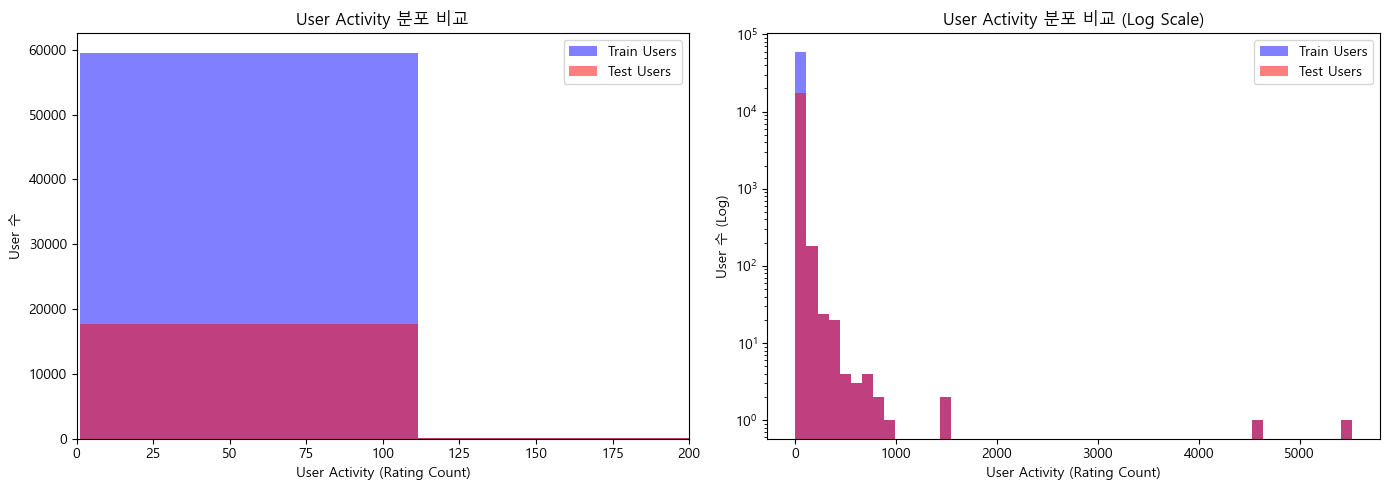

In [39]:
# 시각화: User Activity 분포 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
ax1 = axes[0]
ax1.hist(train_user_activity, bins=50, alpha=0.5, label='Train Users', color='blue')
ax1.hist(test_user_activity, bins=50, alpha=0.5, label='Test Users', color='red')
ax1.set_xlabel('User Activity (Rating Count)')
ax1.set_ylabel('User 수')
ax1.set_title('User Activity 분포 비교')
ax1.legend()
ax1.set_xlim(0, 200)

# Log scale
ax2 = axes[1]
ax2.hist(train_user_activity, bins=50, alpha=0.5, label='Train Users', color='blue')
ax2.hist(test_user_activity, bins=50, alpha=0.5, label='Test Users', color='red')
ax2.set_xlabel('User Activity (Rating Count)')
ax2.set_ylabel('User 수 (Log)')
ax2.set_title('User Activity 분포 비교 (Log Scale)')
ax2.legend()
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

In [40]:
# Train vs Test Item Popularity 분포 비교
print("\n[Train vs Test Item Popularity 분포 비교]")

# Train Item의 popularity 분포 (Item 단위)
train_item_pop = item_stats['item_rating_count']

# Test에 등장하는 Item의 popularity 분포
test_item_ids = test['isbn'].unique()
test_item_pop = item_stats[item_stats['isbn'].isin(test_item_ids)]['item_rating_count']

print(f"Train Item Popularity 통계:")
print(train_item_pop.describe())

print(f"\nTest Item Popularity 통계 (Train 기준):")
print(test_item_pop.describe())


[Train vs Test Item Popularity 분포 비교]
Train Item Popularity 통계:
count    129777.000000
mean          2.364017
std           6.410544
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         566.000000
Name: item_rating_count, dtype: float64

Test Item Popularity 통계 (Train 기준):
count    32207.000000
mean         5.758717
std         12.218919
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max        566.000000
Name: item_rating_count, dtype: float64


In [41]:
# Test의 Category 분포 vs Train
print("\n[Train vs Test Category 분포 비교]")

train_cat_dist = train_merged['category_main'].value_counts(normalize=True).head(10) * 100
test_cat_dist = test_merged['category_main'].value_counts(normalize=True).head(10) * 100

cat_dist_compare = pd.DataFrame({
    'Train (%)': train_cat_dist,
    'Test (%)': test_cat_dist
}).fillna(0).round(2)

print(cat_dist_compare)


[Train vs Test Category 분포 비교]
                           Train (%)  Test (%)
category_main                                 
Biography & Autobiography       4.12      4.09
Body, Mind & Spirit             0.93      0.95
Business & Economics            0.00      0.85
Family & Relationships          0.82      0.00
Fiction                        58.50     58.41
History                         1.44      1.47
Humor                           1.69      1.73
Juvenile Fiction                6.48      6.52
Juvenile Nonfiction             0.89      0.89
Religion                        1.29      1.24
Social Science                  0.88      0.91


In [42]:
# Test의 출판연도 분포 vs Train
print("\n[Train vs Test 출판연도 분포 비교]")

train_year = train_merged['year_of_publication']
test_year = test_merged['year_of_publication']

print(f"Train 평균 출판연도: {train_year.mean():.0f}")
print(f"Test 평균 출판연도: {test_year.mean():.0f}")

# 연도 구간별 비교
year_bins = [0, 1980, 1990, 2000, 2010]
year_labels = ['~1979', '1980-1989', '1990-1999', '2000+']

train_year_dist = pd.cut(train_year, bins=year_bins, labels=year_labels).value_counts(normalize=True) * 100
test_year_dist = pd.cut(test_year, bins=year_bins, labels=year_labels).value_counts(normalize=True) * 100

year_dist_compare = pd.DataFrame({
    'Train (%)': train_year_dist,
    'Test (%)': test_year_dist
}).round(2)

print(f"\n연도 구간별 분포:")
print(year_dist_compare)


[Train vs Test 출판연도 분포 비교]
Train 평균 출판연도: 1996
Test 평균 출판연도: 1996

연도 구간별 분포:
                     Train (%)  Test (%)
year_of_publication                     
1990-1999                53.12     53.05
2000+                    28.54     28.62
1980-1989                14.60     14.57
~1979                     3.74      3.76


In [43]:
# Test User의 Train에서의 평균 Rating (예측에 활용 가능)
print("\n[Test User의 Train Rating 통계]")

# Test에 등장하는 User (Cold User 제외)의 Train에서의 평균 rating
test_warm_users = test_merged[test_merged['user_rating_count'].notna()]

print(f"Warm User interaction: {len(test_warm_users):,}개")
print(f"해당 User들의 Train 평균 Rating: {test_warm_users['user_rating_mean'].mean():.2f}")
print(f"해당 User들의 Train Rating 표준편차: {test_warm_users['user_rating_std'].mean():.2f}")


[Test User의 Train Rating 통계]
Warm User interaction: 68,022개
해당 User들의 Train 평균 Rating: 7.08
해당 User들의 Train Rating 표준편차: 1.93


In [44]:
# Test Item의 Train에서의 평균 Rating
print("\n[Test Item의 Train Rating 통계]")

test_warm_items = test_merged[test_merged['item_rating_count'].notna()]

print(f"Warm Item interaction: {len(test_warm_items):,}개")
print(f"해당 Item들의 Train 평균 Rating: {test_warm_items['item_rating_mean'].mean():.2f}")
print(f"해당 Item들의 Train Rating 표준편차: {test_warm_items['item_rating_std'].mean():.2f}")


[Test Item의 Train Rating 통계]
Warm Item interaction: 56,906개
해당 Item들의 Train 평균 Rating: 7.14
해당 Item들의 Train Rating 표준편차: 2.08


---
## Step 5 요약

**결과를 복사해서 공유해주세요!**

핵심 확인 사항:
1. Heavy User의 특성과 영향
2. 1-rating User/Item의 특성
3. User-Item 매칭 패턴
4. 저평점 vs 고평점 특성
5. 고전 vs 최신 패턴
6. Cold Start 대응 가능성 (Author/Publisher 활용)
7. Author의 예측력
8. Train vs Test 분포 차이